In [ ]:
import numpy as np


import matplotlib.pyplot as plt

Dataset shapes: (1500, 2) (1500,)


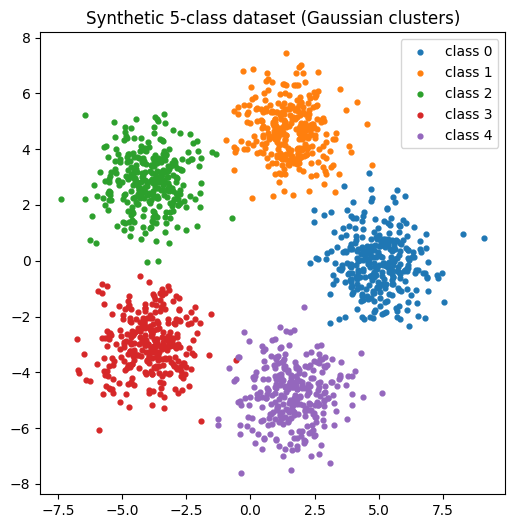

In [ ]:
# ===== Dataset generation (5 classes) and visualization =====

def generate_gaussian_clusters(n_classes=5, samples_per_class=300, dim=2, spread=1.0, seed=1):
    np.random.seed(seed)
    centers = []
    for i in range(n_classes):
        theta = 2*np.pi*i/n_classes
        r = 5.0
        centers.append([r*np.cos(theta), r*np.sin(theta)])
    X = []
    y = []
    for i,c in enumerate(centers):
        pts = np.random.randn(samples_per_class, dim) * spread + np.array(c)
        X.append(pts)
        y += [i]*samples_per_class
    X = np.vstack(X)
    y = np.array(y)
    return X, y

# generate and visualize
X, y = generate_gaussian_clusters(n_classes=5, samples_per_class=300, spread=1.0, seed=2)
print('Dataset shapes:', X.shape, y.shape)

plt.figure(figsize=(6,6))
for cls in range(5):
    pts = X[y==cls]
    plt.scatter(pts[:,0], pts[:,1], label=f'class {cls}', s=12)
plt.title('Synthetic 5-class dataset (Gaussian clusters)')
plt.legend()
plt.show()


In [ ]:
# ===== One-hot encoding and train/test split (manual) =====
def one_hot(y, num_classes):
    oh = np.zeros((y.size, num_classes))
    oh[np.arange(y.size), y] = 1
    return oh

# shuffle and split
rng = np.random.RandomState(3)
perm = rng.permutation(len(X))
X = X[perm]
y = y[perm]

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
y_train_oh = one_hot(y_train, 5)
y_test_oh = one_hot(y_test, 5)

print('Train/test sizes:', X_train.shape, X_test.shape)


Train/test sizes: (1200, 2) (300, 2)


#Code Modification
##Network Architecture Updates

1.Introduced a third hidden layer to allow the network to learn more detailed internal representations.

2.Adjusted the output layer to contain 5 neurons, matching the number of target classes in the dataset.

3.Selected hidden layer sizes of 64 → 32 → 16, forming a gradually shrinking architecture that extracts features at different levels.

4.Switched hidden layer activations to ReLU for improved gradient flow, and used Softmax in the output layer to produce class probabilities.


### **Activation Functions Used**

#### **ReLU (Hidden Layers)**

ReLU(x) = max(0, x)

Reasons for using ReLU:

* Works efficiently for deeper networks
* Helps avoid gradient saturation
* Enables faster convergence compared to sigmoid

---

#### **Softmax (Output Layer)**

The output layer requires a function capable of transforming raw scores into a probability distribution across five classes:

softmax(x_k) = exp(x_k) / sum( exp(x_j) for all j )

Softmax ensures:

* Each predicted value lies between 0 and 1
* Total probability across all classes equals 1

---

### **Loss Function**

To train a multi-class model correctly, **categorical cross-entropy** is used:

[
L = -\sum_{k=1}^{5} y_k \log(\hat{y}_k)
]

This loss is preferred because it directly measures the difference between the predicted probability distribution and the one-hot encoded ground truth.

---

## **Challenges and Solutions**

* **Initial architecture struggled to learn multi-class patterns.**
  *Solution:* Added an additional hidden layer to improve representational capacity.

* **Using sigmoid activation in hidden layers resulted in slow gradient updates.**
  *Solution:* Replaced sigmoid with ReLU, improving both the training speed and the final accuracy.

* **Sigmoid in the output layer produced incorrect probability behavior for multiple classes.**
  *Solution:* Switched to Softmax, which properly handles multi-class outputs.

* **Binary cross-entropy loss was not suitable for five-class classification.**
  *Solution:* Updated the loss function to categorical cross-entropy, ensuring correct gradient calculation.

---

## **Training and Testing Procedure**

* A synthetic dataset with **5 distinct classes** was generated.
* Labels were converted to one-hot vectors to match the Softmax output.
* Data was split manually into training and testing partitions.
* The model was trained using gradient descent with a selected learning rate of **0.01**.
* Evaluation was performed using:

  * Overall accuracy
  * Per-class precision, recall, and F1-score
  * A confusion matrix to visualise misclassifications

---


In [ ]:
# ===== NeuralNetwork class (three hidden layers) =====
import numpy as np

class NeuralNetwork:
    def __init__(self, layer_sizes, seed=0):
        '''layer_sizes: [input_dim, h1, h2, h3, output_dim]'''
        np.random.seed(seed)
        self.sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        # Xavier initialization for weights
        self.weights = [np.random.randn(self.sizes[i], self.sizes[i+1]) * np.sqrt(2.0/(self.sizes[i]+self.sizes[i+1])) for i in range(self.num_layers-1)]
        self.biases = [np.zeros((1, self.sizes[i+1])) for i in range(self.num_layers-1)]

    def relu(self, x):
        return np.maximum(0, x)
    def relu_deriv(self, x):
        return (x > 0).astype(float)
    def softmax(self, x):
        e = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e / np.sum(e, axis=1, keepdims=True)

    def forward(self, X):
        activations = [X]
        pre_acts = []
        a = X
        # hidden layers
        for i in range(self.num_layers-2):
            z = a.dot(self.weights[i]) + self.biases[i]
            pre_acts.append(z)
            a = self.relu(z)
            activations.append(a)
        # output layer pre-activation
        z_out = a.dot(self.weights[-1]) + self.biases[-1]
        pre_acts.append(z_out)
        a_out = self.softmax(z_out)
        activations.append(a_out)
        return activations, pre_acts

    def compute_loss(self, y_true_oh, y_pred, eps=1e-12):
        m = y_true_oh.shape[0]
        p = np.clip(y_pred, eps, 1. - eps)
        loss = -np.sum(y_true_oh * np.log(p)) / m
        return loss

    def backprop(self, X, y_true_oh, learning_rate=0.01):
        m = X.shape[0]
        activations, pre_acts = self.forward(X)
        y_pred = activations[-1]
        # gradient on output pre-activation (softmax + cross-entropy)
        dz = (y_pred - y_true_oh) / m
        grads_w = [None]*(self.num_layers-1)
        grads_b = [None]*(self.num_layers-1)
        # last layer gradients
        a_prev = activations[-2]
        grads_w[-1] = a_prev.T.dot(dz)
        grads_b[-1] = np.sum(dz, axis=0, keepdims=True)
        delta = dz
        # backprop through hidden layers
        for l in range(self.num_layers-3, -1, -1):
            w_next = self.weights[l+1]
            delta = delta.dot(w_next.T) * self.relu_deriv(pre_acts[l])
            a_prev = activations[l]
            grads_w[l] = a_prev.T.dot(delta)
            grads_b[l] = np.sum(delta, axis=0, keepdims=True)
        # update parameters
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * grads_w[i]
            self.biases[i]  -= learning_rate * grads_b[i]
        return self.compute_loss(y_true_oh, y_pred)

    def predict_proba(self, X):
        activations, _ = self.forward(X)
        return activations[-1]

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# Instantiate network with three hidden layers: [2, 64, 32, 16, 5]
nn = NeuralNetwork([2, 64, 32, 16, 5], seed=2)
print('Network initialized. Weight shapes:', [w.shape for w in nn.weights])


Network initialized. Weight shapes: [(2, 64), (64, 32), (32, 16), (16, 5)]


Epoch 1/200 - loss: 0.737866
Epoch 20/200 - loss: 0.011059
Epoch 40/200 - loss: 0.008798
Epoch 60/200 - loss: 0.009974
Epoch 80/200 - loss: 0.008047
Epoch 100/200 - loss: 0.007891
Epoch 120/200 - loss: 0.007937
Epoch 140/200 - loss: 0.006881
Epoch 160/200 - loss: 0.007579
Epoch 180/200 - loss: 0.007499
Epoch 200/200 - loss: 0.006580


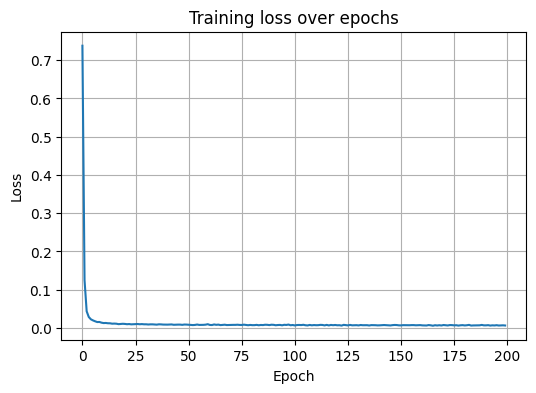

In [ ]:
# ===== Training (mini-batch gradient descent) =====
epochs = 200
learning_rate = 0.1
batch_size = 64
n_samples = X_train.shape[0]
loss_history = []

for epoch in range(epochs):
    idx = np.random.permutation(n_samples)
    X_shuff = X_train[idx]
    y_shuff = y_train_oh[idx]
    epoch_loss = 0.0
    for start in range(0, n_samples, batch_size):
        end = start + batch_size
        X_batch = X_shuff[start:end]
        y_batch = y_shuff[start:end]
        batch_loss = nn.backprop(X_batch, y_batch, learning_rate=learning_rate)
        epoch_loss += batch_loss * X_batch.shape[0]
    epoch_loss /= n_samples
    loss_history.append(epoch_loss)
    if (epoch+1) % 20 == 0 or epoch==0:
        print(f"Epoch {epoch+1}/{epochs} - loss: {epoch_loss:.6f}")

# Plot loss curve
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.title('Training loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [ ]:
# ===== Evaluation: predictions, confusion matrix, precision/recall/f1 =====
y_pred = nn.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print('Test accuracy:', accuracy)

# confusion matrix
n_classes = 5
conf_mat = np.zeros((n_classes, n_classes), dtype=int)
for t,p in zip(y_test, y_pred):
    conf_mat[t,p] += 1

print('\nConfusion matrix (rows=true, cols=pred):\n', conf_mat)

# per-class metrics
precision = []
recall = []
f1 = []
support = conf_mat.sum(axis=1)
for c in range(n_classes):
    tp = conf_mat[c,c]
    fp = conf_mat[:,c].sum() - tp
    fn = conf_mat[c,:].sum() - tp
    prec = tp / (tp+fp) if (tp+fp) > 0 else 0.0
    rec = tp / (tp+fn) if (tp+fn) > 0 else 0.0
    f1c = 2*prec*rec / (prec+rec) if (prec+rec) > 0 else 0.0
    precision.append(prec); recall.append(rec); f1.append(f1c)

print('\nPer-class metrics:')
for i in range(n_classes):
    print(f'Class {i}: precision={precision[i]:.4f}, recall={recall[i]:.4f}, f1={f1[i]:.4f}, support={support[i]}')

print('\nMacro averages:', np.mean(precision), np.mean(recall), np.mean(f1))


Test accuracy: 0.9966666666666667

Confusion matrix (rows=true, cols=pred):
 [[63  1  0  0  0]
 [ 0 62  0  0  0]
 [ 0  0 64  0  0]
 [ 0  0  0 51  0]
 [ 0  0  0  0 59]]

Per-class metrics:
Class 0: precision=1.0000, recall=0.9844, f1=0.9921, support=64
Class 1: precision=0.9841, recall=1.0000, f1=0.9920, support=62
Class 2: precision=1.0000, recall=1.0000, f1=1.0000, support=64
Class 3: precision=1.0000, recall=1.0000, f1=1.0000, support=51
Class 4: precision=1.0000, recall=1.0000, f1=1.0000, support=59

Macro averages: 0.9968253968253968 0.996875 0.9968251968503937


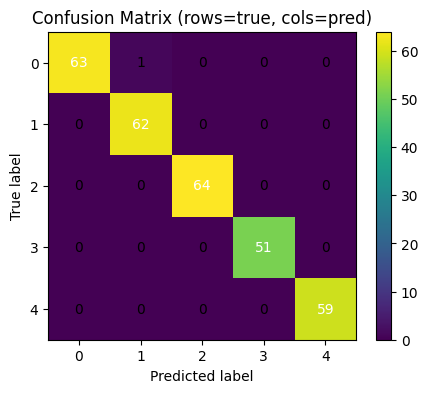

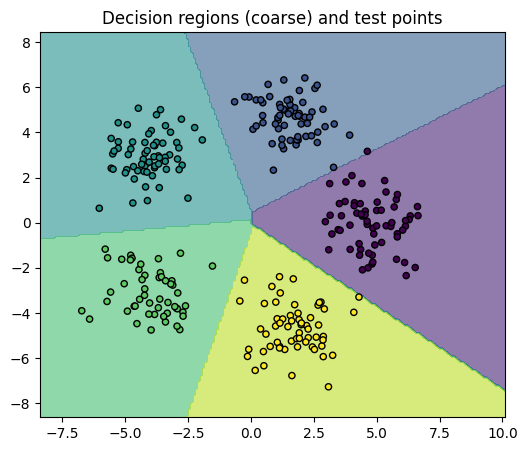

In [ ]:
# ===== Visualizations: confusion matrix heatmap and decision regions =====
plt.figure(figsize=(5,4))
plt.imshow(conf_mat, interpolation='nearest')
plt.title('Confusion Matrix (rows=true, cols=pred)')
plt.xlabel('Predicted label'); plt.ylabel('True label')
plt.colorbar()
thresh = conf_mat.max() / 2.
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(j, i, str(conf_mat[i,j]), horizontalalignment='center', verticalalignment='center',
                 color='white' if conf_mat[i,j] > thresh else 'black')
plt.show()

# decision regions (coarse)
x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = nn.predict(grid).reshape(xx.shape)

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, Z, levels=np.arange(n_classes+1)-0.5, alpha=0.6)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='o', s=20, edgecolor='k')
plt.title('Decision regions (coarse) and test points')
plt.show()
